# Business Data Analytics Project 04.15.

## First steps - importing libraries and reading the file


In [ ]:
!pip install --upgrade gspread google-auth-httplib2 google-auth-oauthlib

from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

# Open GSheet by URL
worksheet = gc.open_by_url('https://docs.google.com/spreadsheets/d/1NVzwcDDxE7SlUDxQps7TKRUG35KtAg2eoKiIJxGMwyc/edit?usp=sharing').sheet1

# Get all values from the sheet
data = worksheet.get_all_values()

# Convert the list of lists to a pandas DataFrame
import pandas as pd
df = pd.DataFrame(data[1:], columns=data[0])

# Data Preparation and brief Exploration

##Get to know the dataset

In [ ]:
# First look at the head
display(df.head())

# Check info
print(df.info())

Age Sex ChestPainType RestingBP Cholesterol FastingBS RestingECG MaxHR  \
0  40   M           ATA       140         289         0     Normal   172   
1  49   F           NAP       160         180         0     Normal   156   
2  37   M           ATA       130         283         0         ST    98   
3  48   F           ASY       138         214         0     Normal   108   
4  54   M           NAP       150         195         0     Normal   122   

  ExerciseAngina Oldpeak ST_Slope HeartDisease  
0              N       0       Up            0  
1              N       1     Flat            1  
2              N       0       Up            0  
3              Y     1.5     Flat            1  
4              N       0       Up            0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             918 non-null    object
 1   Sex             918 non-null    object
 2   ChestPainType   918 non-null    object
 3   RestingBP       918 non-null    object
 4   Cholesterol     918 non-null    object
 5   FastingBS       918 non-null    object
 6   RestingECG      918 non-null    object
 7   MaxHR           918 non-null    object
 8   ExerciseAngina  918 non-null    object
 9   Oldpeak         918 non-null    object
 10  ST_Slope        918 non-null    object
 11  HeartDisease    918 non-null    object
dtypes: object(12)
memory usage: 86.2+ KB
None


In [ ]:
# Check desriptive statistics
print(df.describe())

# See columns
print(df.columns)

        Age  Sex ChestPainType RestingBP Cholesterol FastingBS RestingECG  \
count   918  918           918       918         918       918        918   
unique   50    2             4        67         222         2          3   
top      54    M           ASY       120           0         0     Normal   
freq     51  725           496       132         172       704        552   

       MaxHR ExerciseAngina Oldpeak ST_Slope HeartDisease  
count    918            918     918      918          918  
unique   119              2      53        3            2  
top      150              N       0     Flat            1  
freq      43            547     368      460          508  
Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')


##Data cleaning

###Converting data types and handling missing values

In [ ]:
# Define columns
cols_to_convert = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

#Check non numeric values
for col in cols_to_convert:
    non_numeric = df[~df[col].astype(str).str.match(r'^-?\d+(\.\d+)?$', na=False)][col]
    print(f"{col} - count of non numeric values: {non_numeric.shape[0]}")
    if not non_numeric.empty:
        print(non_numeric.value_counts())

Age - count of non numeric values: 0
RestingBP - count of non numeric values: 0
Cholesterol - count of non numeric values: 0
MaxHR - count of non numeric values: 0
Oldpeak - count of non numeric values: 0


In [ ]:
#Convert needed columns to numeric
for col in cols_to_convert:
    if df[col].dtype not in ['int64', 'float64']:
        df[col] = pd.to_numeric(df[col], errors='coerce')

In [ ]:
df['HeartDisease'] = pd.to_numeric(df['HeartDisease'], errors='coerce')

In [ ]:
print("Number of original rows:", df.shape[0])
print("Number of non complete rows:", df.isnull().any(axis=1).sum())


Number of original rows: 918
Number of non complete rows: 0


In [ ]:
#Convert categorical columns to 'category' dtype
categorical_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
for col in categorical_cols:
    df[col] = df[col].astype('category')

In [ ]:
#Double-check the updated structure
print("\nUpdated data types:")
print(df.dtypes)

print("\nCleaned dataset shape:", df.shape)


Updated data types:
Age                  int64
Sex               category
ChestPainType     category
RestingBP            int64
Cholesterol          int64
FastingBS           object
RestingECG        category
MaxHR                int64
ExerciseAngina    category
Oldpeak            float64
ST_Slope          category
HeartDisease         int64
dtype: object

Cleaned dataset shape: (918, 12)


###One-hot encoding

In [ ]:
#Check if there is high cardinality columns (>15)
for col in categorical_cols:
    print(f"{col}: {df[col].nunique()} unique value")
    print(df[col].value_counts().head(), '\n')

Sex: 2 unique value
Sex
M    725
F    193
Name: count, dtype: int64 

ChestPainType: 4 unique value
ChestPainType
ASY    496
NAP    203
ATA    173
TA      46
Name: count, dtype: int64 

RestingECG: 3 unique value
RestingECG
Normal    552
LVH       188
ST        178
Name: count, dtype: int64 

ExerciseAngina: 2 unique value
ExerciseAngina
N    547
Y    371
Name: count, dtype: int64 

ST_Slope: 3 unique value
ST_Slope
Flat    460
Up      395
Down     63
Name: count, dtype: int64 



In [ ]:
# One-hot encode and drop the first category to avoid multicollinearity
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True, dtype=int)

# Show new column names after encoding
print("New columns after One-Hot Encoding:")
print(df_encoded.columns.tolist())

# Check the updated shape
print("\nEncoded dataset shape:", df_encoded.shape)

# Preview the result
display(df_encoded.head())

New columns after One-Hot Encoding:
['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'HeartDisease', 'Sex_M', 'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA', 'RestingECG_Normal', 'RestingECG_ST', 'ExerciseAngina_Y', 'ST_Slope_Flat', 'ST_Slope_Up']

Encoded dataset shape: (918, 16)


Age  RestingBP  Cholesterol FastingBS  MaxHR  Oldpeak  HeartDisease  Sex_M  \
0   40        140          289         0    172      0.0             0      1   
1   49        160          180         0    156      1.0             1      0   
2   37        130          283         0     98      0.0             0      1   
3   48        138          214         0    108      1.5             1      0   
4   54        150          195         0    122      0.0             0      1   

   ChestPainType_ATA  ChestPainType_NAP  ChestPainType_TA  RestingECG_Normal  \
0                  1                  0                 0                  1   
1                  0                  1                 0                  1   
2                  1                  0                 0                  0   
3                  0                  0                 0                  1   
4                  0                  1                 0                  1   

   RestingECG_ST  ExerciseAngina_Y  ST_Slope_Flat  ST_Slope_Up  
0              0                 0              0            1  
1              0                 0              1            0  
2              1                 0              0            1  
3              0                 1              1            0  
4              0                 0              0            1

###Looking for outliers

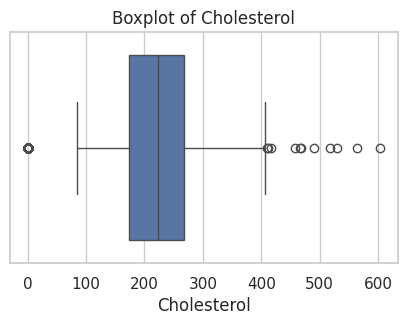

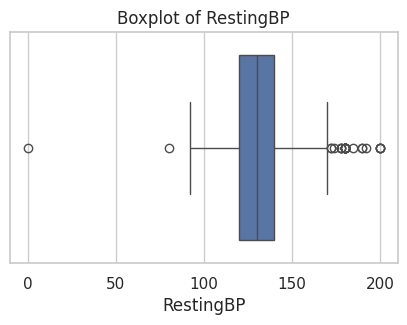

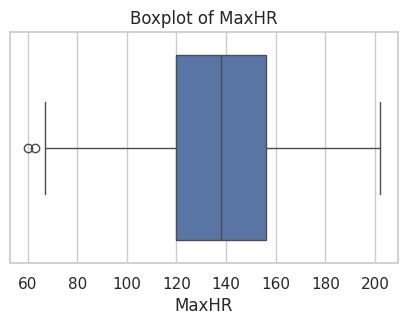

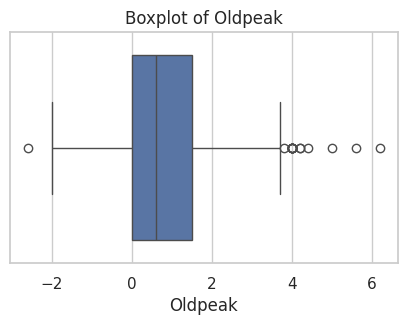

In [ ]:
#Outlier check
import matplotlib.pyplot as plt
import seaborn as sns

for col in ['Cholesterol', 'RestingBP', 'MaxHR', 'Oldpeak']:
    plt.figure(figsize=(5, 3))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

In [ ]:
# Function to detect outliers using the IQR method (exploration only, not for removal)
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower) | (df[column] > upper)]
    return outliers

# Example
outliers_chol = detect_outliers_iqr(df, 'Cholesterol')
print("Outliers in Cholesterol:", len(outliers_chol))

Outliers in Cholesterol: 183


In [ ]:
#Clip Oldpeak values at the 99th percentile
upper = df['Oldpeak'].quantile(0.99)
df['Oldpeak_clipped'] = df['Oldpeak'].clip(upper=upper)

In [ ]:
# Clip Cholesterol values at the 99th percentile to reduce extreme influence
upper_chol = df['Cholesterol'].quantile(0.99)
df['Cholesterol_clipped'] = df['Cholesterol'].clip(upper=upper_chol)

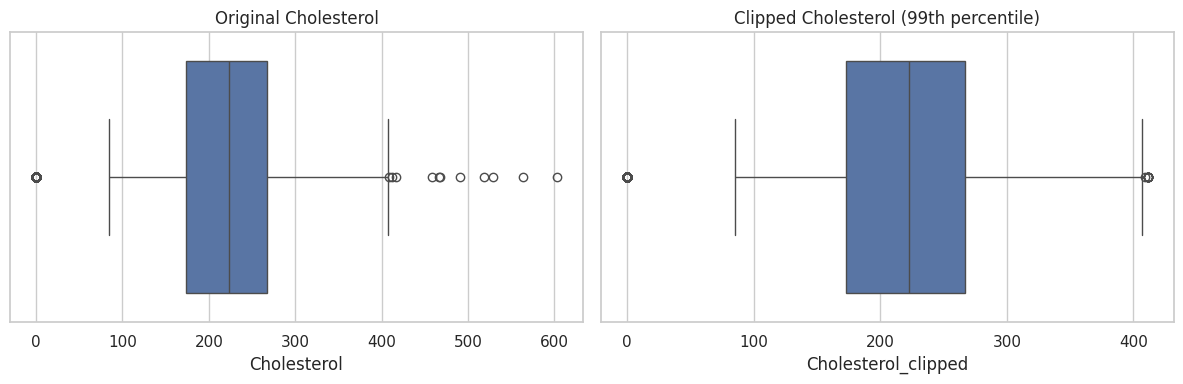

In [ ]:
#Comparison plot original Cholesterol vs. clipped Cholesterol values
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.boxplot(x=df['Cholesterol'])
plt.title("Original Cholesterol")

plt.subplot(1, 2, 2)
sns.boxplot(x=df['Cholesterol_clipped'])
plt.title("Clipped Cholesterol (99th percentile)")

plt.tight_layout()
plt.show()

In [ ]:
# Check duplicates
print(df.duplicated().any())
print(df.duplicated().sum())

False
0


In [ ]:
# Check the shape
print(df.shape)

(918, 14)


In [ ]:
#Print head
print(df.head)

<bound method NDFrame.head of      Age Sex ChestPainType  RestingBP  Cholesterol FastingBS RestingECG  \
0     40   M           ATA        140          289         0     Normal   
1     49   F           NAP        160          180         0     Normal   
2     37   M           ATA        130          283         0         ST   
3     48   F           ASY        138          214         0     Normal   
4     54   M           NAP        150          195         0     Normal   
..   ...  ..           ...        ...          ...       ...        ...   
913   45   M            TA        110          264         0     Normal   
914   68   M           ASY        144          193         1     Normal   
915   57   M           ASY        130          131         0     Normal   
916   57   F           ATA        130          236         0        LVH   
917   38   M           NAP        138          175         0     Normal   

     MaxHR ExerciseAngina  Oldpeak ST_Slope  HeartDisease  Oldpeak_cl

In [ ]:
# Set df to final encoded and preprocessed dataset
df = df_encoded.copy()

#Train-Test Split

In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix,
    classification_report, roc_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Define X and y
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

# Stratified train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#Exploratory Data Analysis



In [ ]:
# Set style for the plots
sns.set(style="whitegrid")

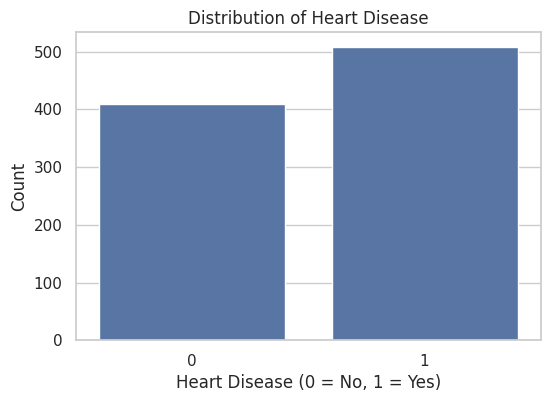

In [ ]:
#Target variable distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='HeartDisease')
plt.title("Distribution of Heart Disease")
plt.xlabel("Heart Disease (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

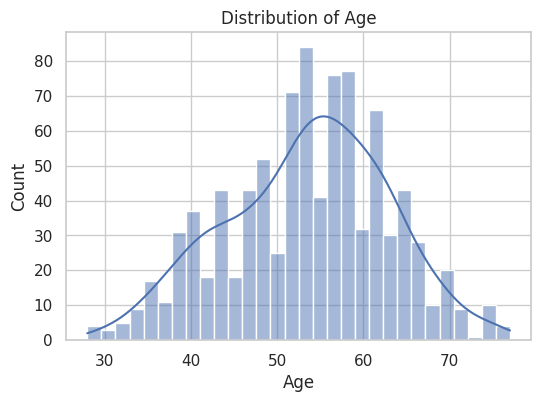

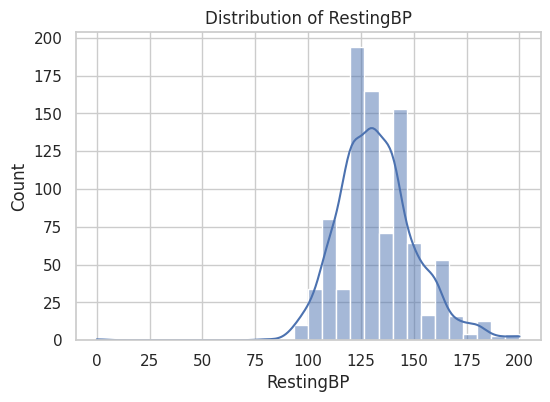

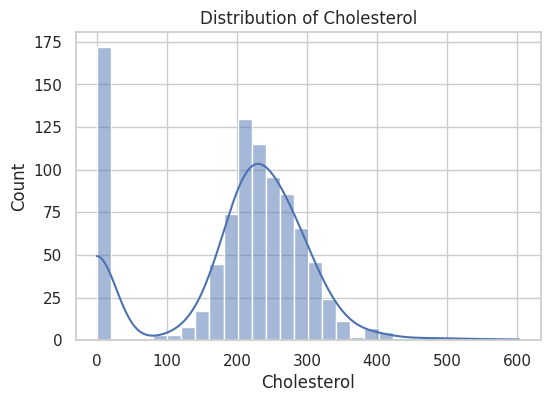

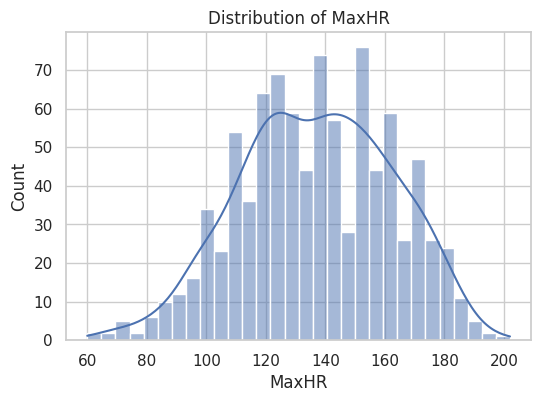

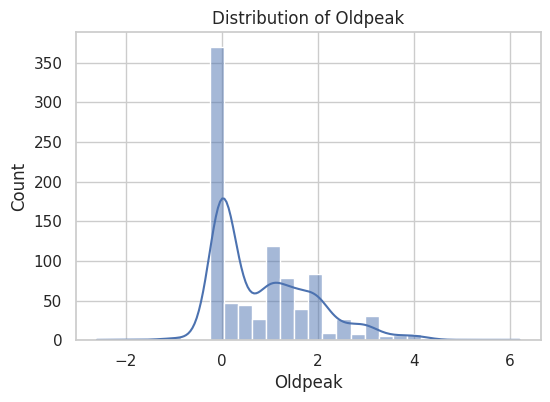

In [ ]:
#Distribution plots for numeric features
numeric_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.show()

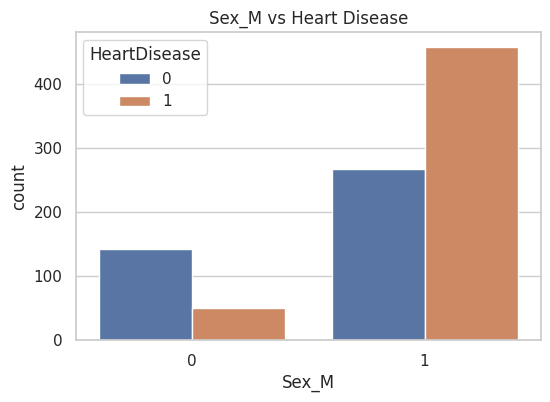

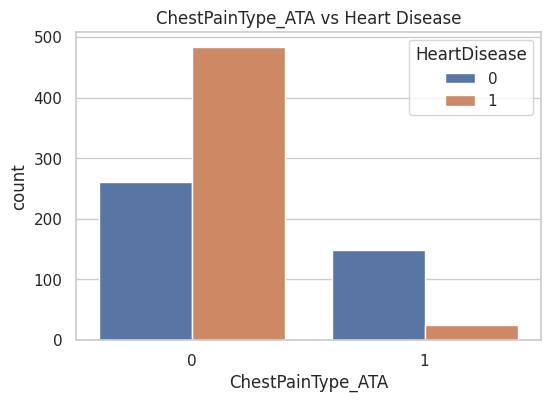

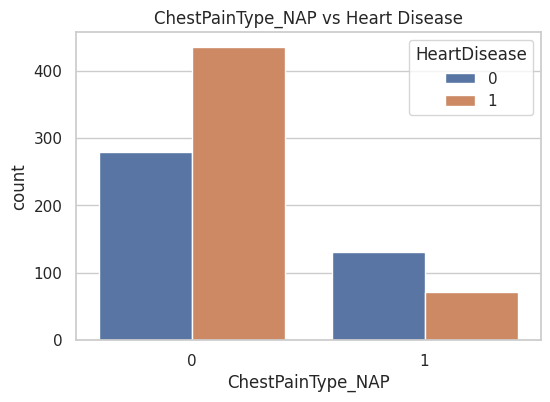

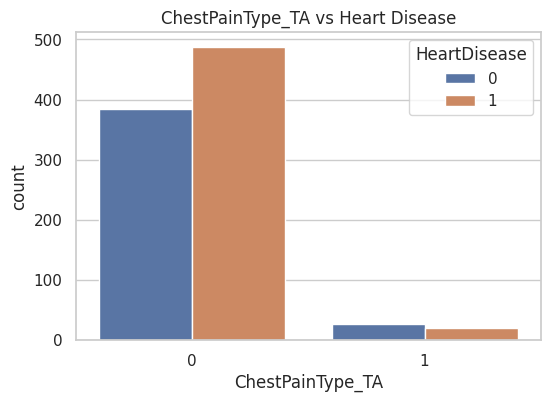

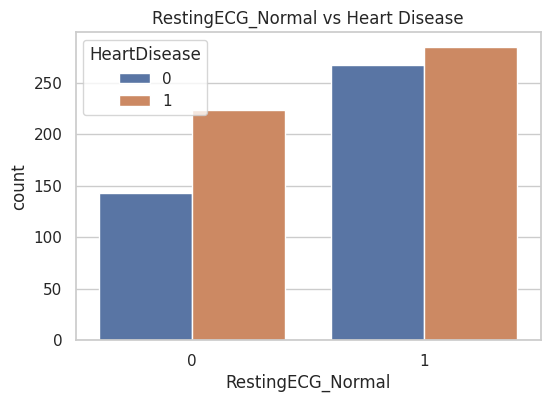

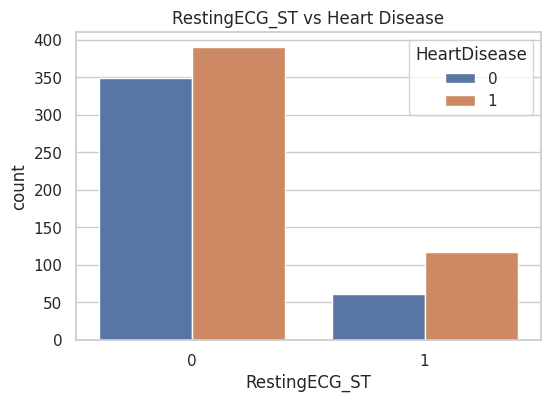

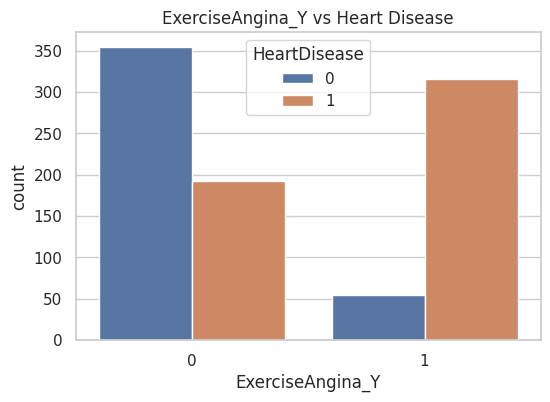

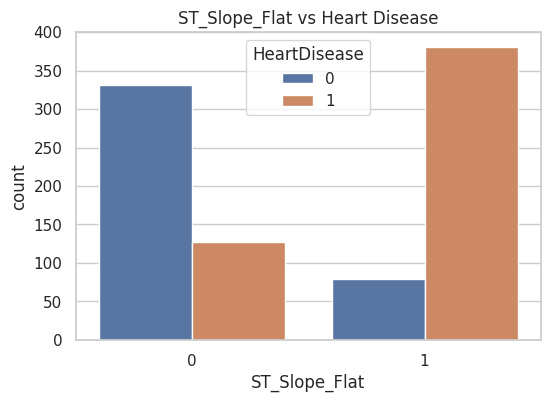

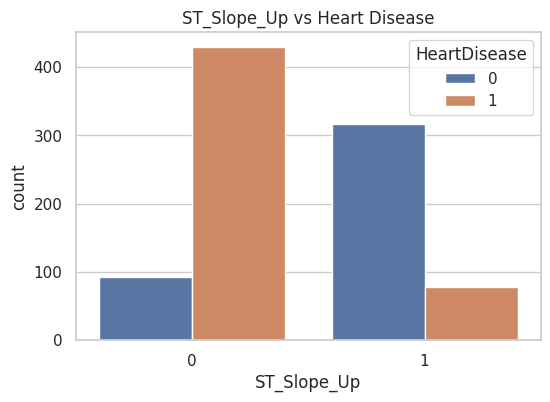

In [ ]:
#Categorical feature counts
encoded_categorical_cols = [col for col in df.columns if col.startswith(('Sex_', 'ChestPainType_', 'RestingECG_', 'ExerciseAngina_', 'ST_Slope_'))]

for col in encoded_categorical_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=df, x=col, hue='HeartDisease')
    plt.title(f"{col} vs Heart Disease")
    plt.legend(title="HeartDisease")
    plt.show()

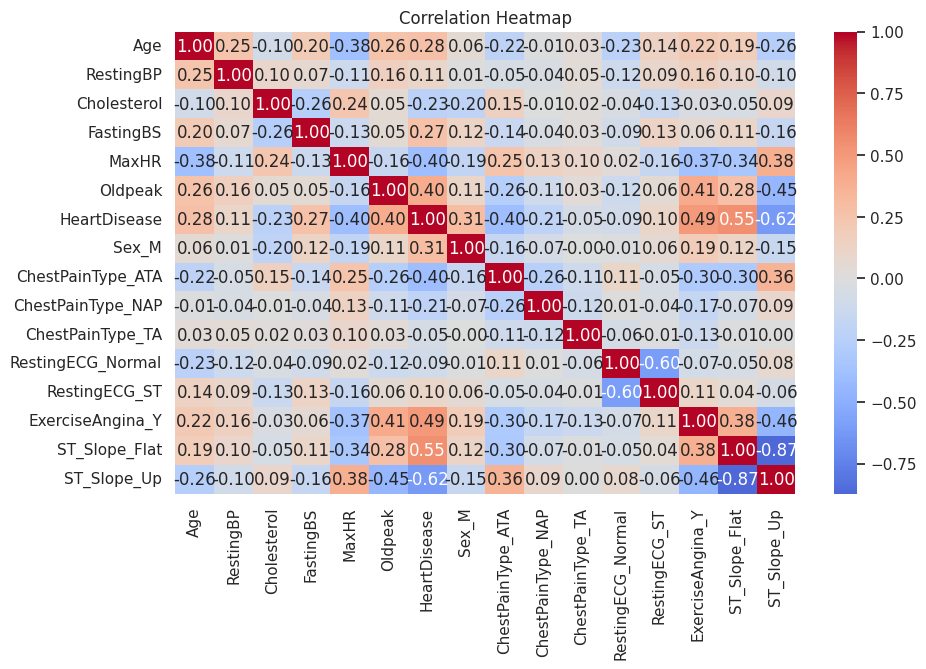

In [ ]:
# Correlation heatmap centered at 0 to better highlight positive vs. negative relationships
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()

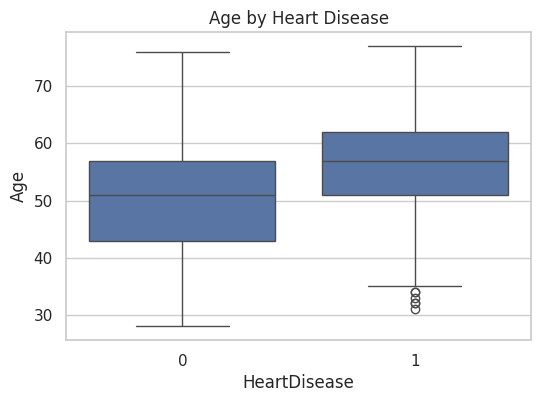

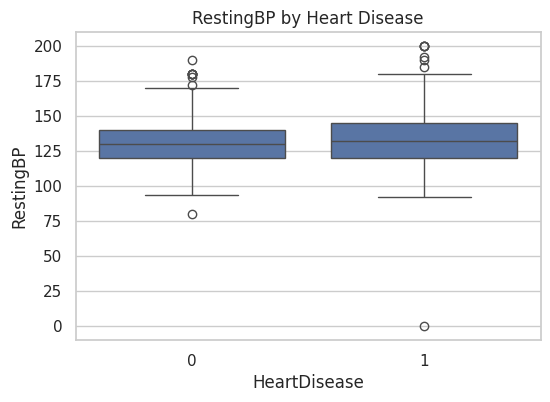

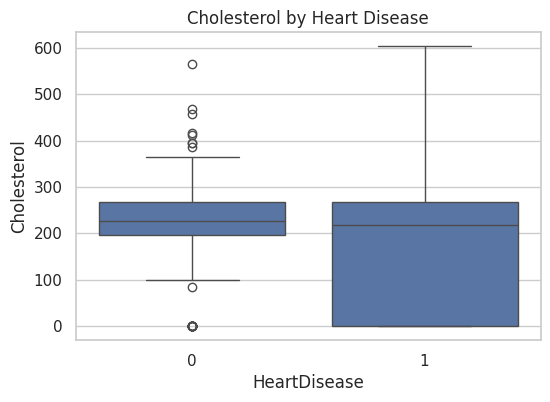

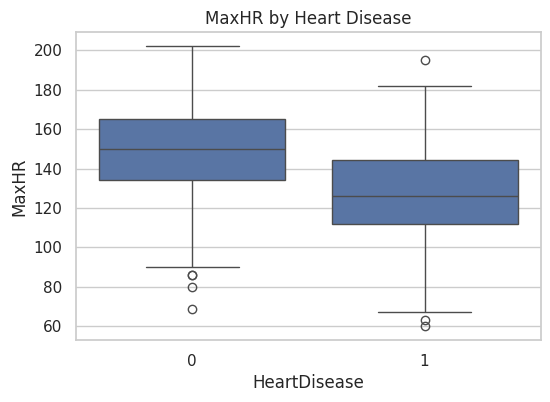

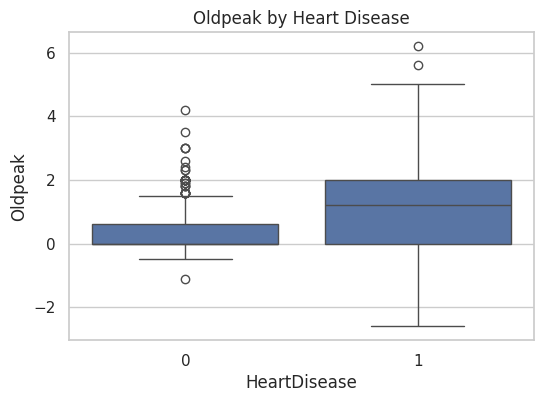

In [ ]:
#Boxplots by HeartDisease
for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df, x='HeartDisease', y=col)
    plt.title(f"{col} by Heart Disease")
    plt.show()

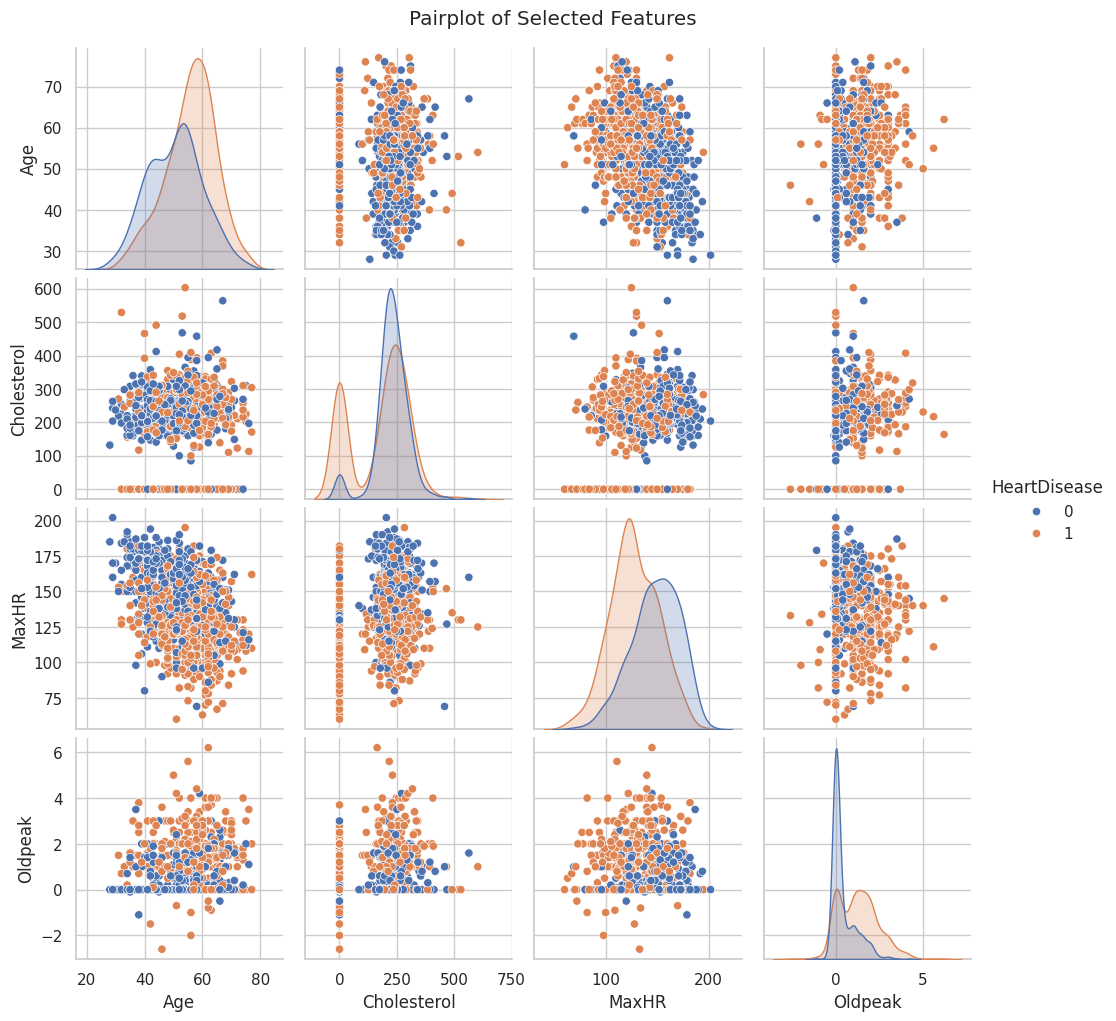

In [ ]:
# Pairplot for selected numeric features + target
selected_cols = ['Age', 'Cholesterol', 'MaxHR', 'Oldpeak', 'HeartDisease']
sns.pairplot(df[selected_cols], hue='HeartDisease')
plt.suptitle("Pairplot of Selected Features", y=1.02)
plt.show()

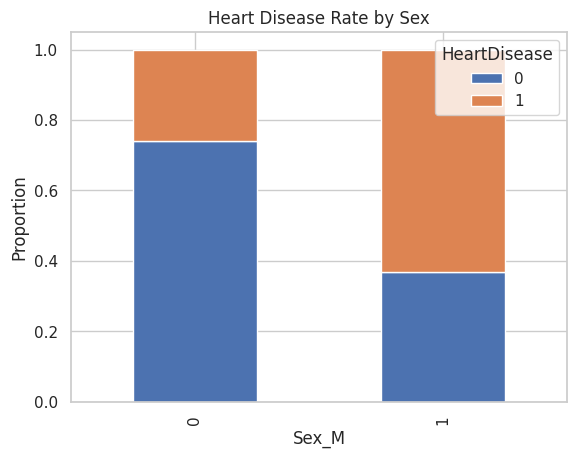

In [ ]:
#Cross-tab for Sex vs HeartDisease
pd.crosstab(df['Sex_M'], df['HeartDisease'], normalize='index').plot(kind='bar', stacked=True)
plt.title("Heart Disease Rate by Sex")
plt.ylabel("Proportion")
plt.show()

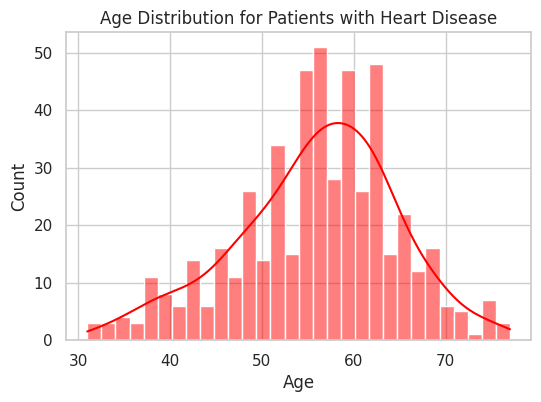

In [ ]:
# Filter: Only rows with HeartDisease = 1
df_hd = df[df['HeartDisease'] == 1]

# Plot Age distribution
plt.figure(figsize=(6, 4))
sns.histplot(df_hd['Age'], bins=30, kde=True, color='red')
plt.title("Age Distribution for Patients with Heart Disease")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

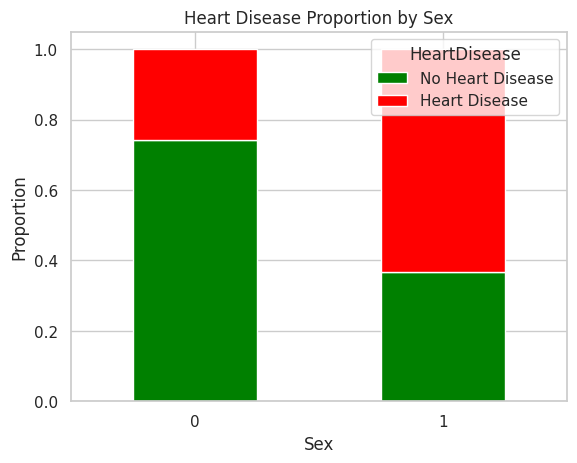

In [ ]:
# Cross-tab and stacked bar chart
sex_hd = pd.crosstab(df['Sex_M'], df['HeartDisease'], normalize='index') #Corrected line to use 'Sex_M'

# Plot
sex_hd.plot(kind='bar', stacked=True, color=['green', 'red'])
plt.title("Heart Disease Proportion by Sex")
plt.ylabel("Proportion")
plt.xlabel("Sex")
plt.legend(["No Heart Disease", "Heart Disease"], title="HeartDisease")
plt.xticks(rotation=0)
plt.show()

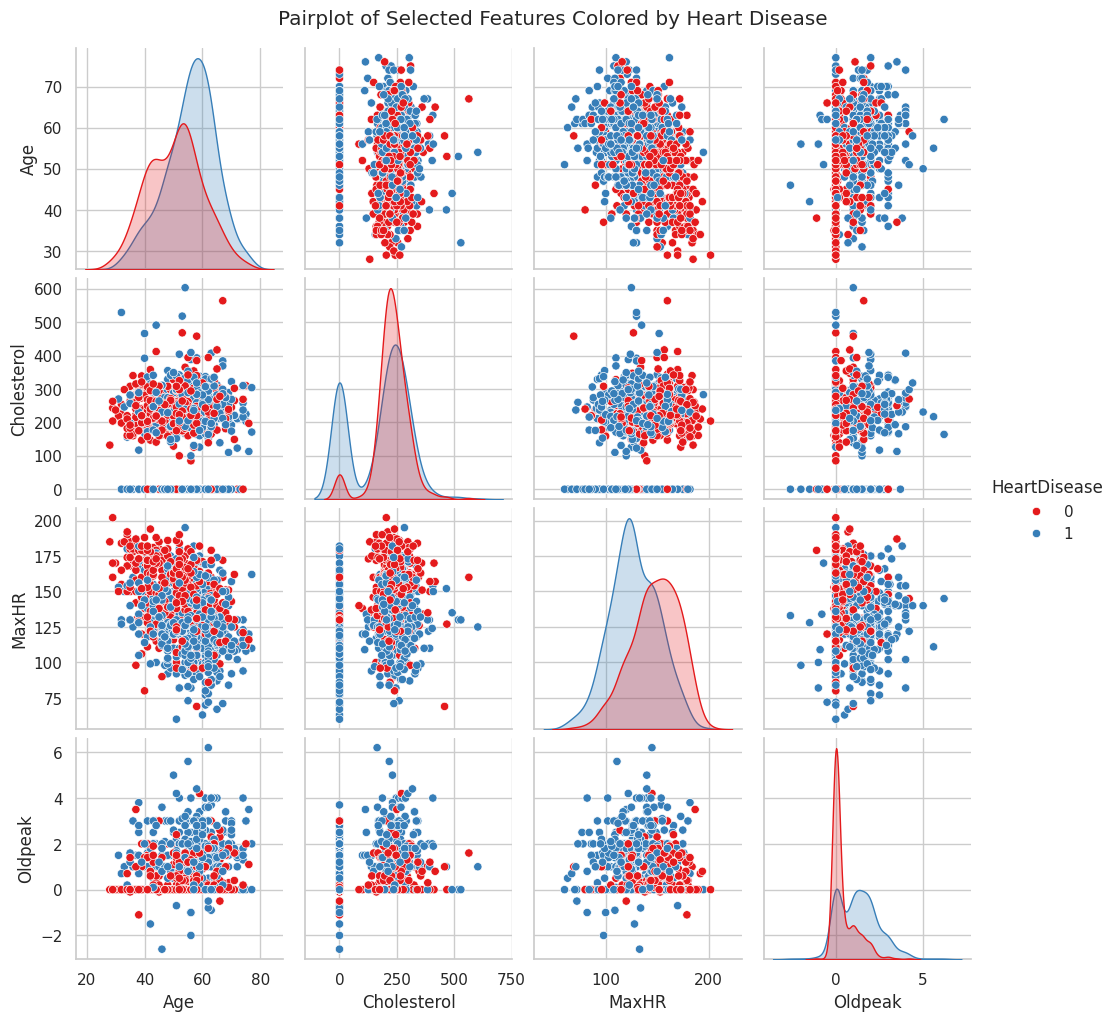

In [ ]:
# Select relevant features
selected_cols = ['Age', 'Cholesterol', 'MaxHR', 'Oldpeak', 'HeartDisease']

# Pairplot
sns.pairplot(df[selected_cols], hue='HeartDisease', palette='Set1')
plt.suptitle("Pairplot of Selected Features Colored by Heart Disease", y=1.02)
plt.show()


#Feature engineering

##Scale features for Linear Model

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [1]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(max_iter=1000))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

NameError: name 'Pipeline' is not defined

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='f1')
print("Cross-validated F1 scores:", scores)

Cross-validated F1 scores: [0.89171975 0.8875     0.87804878 0.84848485 0.88095238]


In [ ]:
#Logistic Regression (L1 regularization)
from sklearn.preprocessing import StandardScaler

#Create X_scaled
X_scaled = StandardScaler().fit_transform(X)
logreg = LogisticRegression(penalty='l1', solver='liblinear')
logreg.fit(X_scaled, y)
importance_lr = pd.Series(logreg.coef_[0], index=X.columns)


In [ ]:
#Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)
importance_rf = pd.Series(rf.feature_importances_, index=X.columns)

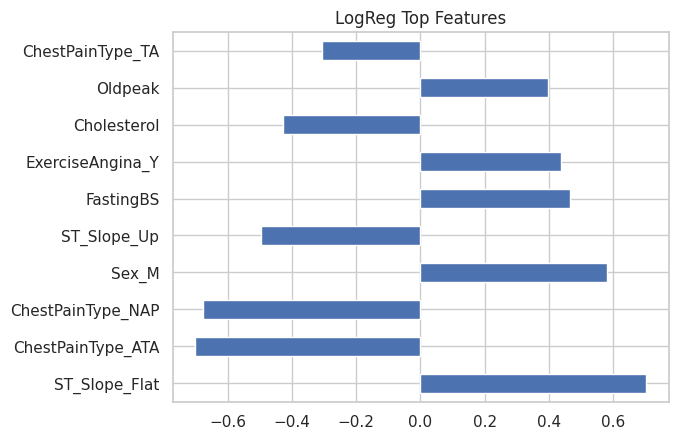

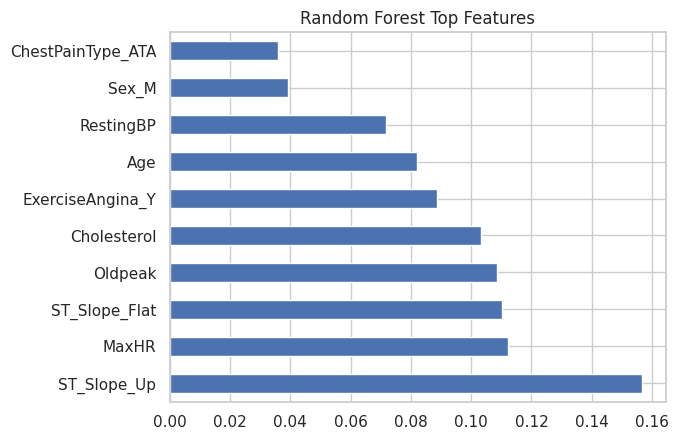

In [ ]:
#Plot
importance_lr.sort_values(key=abs, ascending=False).head(10).plot(kind='barh', title="LogReg Top Features")
plt.show()
importance_rf.sort_values(ascending=False).head(10).plot(kind='barh', title="Random Forest Top Features")
plt.show()

#Correlation Analysis

In [ ]:
#(This is for feature engineering)
# Absolute correlation with target
corr = df.corr()['HeartDisease'].abs().sort_values(ascending=False)
print("Top correlated features:\n", corr.head(10))

Top correlated features:
 HeartDisease         1.000000
ST_Slope_Up          0.622164
ST_Slope_Flat        0.554134
ExerciseAngina_Y     0.494282
Oldpeak              0.403951
ChestPainType_ATA    0.401924
MaxHR                0.400421
Sex_M                0.305445
Age                  0.282039
FastingBS            0.267291
Name: HeartDisease, dtype: float64


##Dimension Reduction

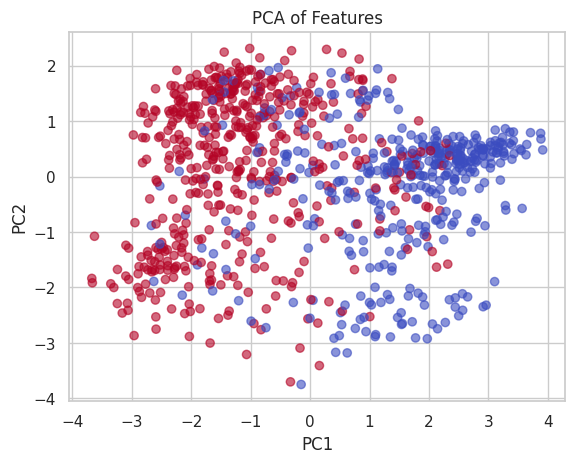

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', alpha=0.6)
plt.title("PCA of Features")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

#SMOTE - Synthetic Minority Oversampling Technique

In [ ]:
!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE

In [ ]:
# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Original class distribution:")
print(y_train.value_counts())

print("\nSMOTE-resampled class distribution:")
print(pd.Series(y_train_smote).value_counts())

Original class distribution:
HeartDisease
1    406
0    328
Name: count, dtype: int64

SMOTE-resampled class distribution:
HeartDisease
1    406
0    406
Name: count, dtype: int64


#Models

##Baseline and ML cLassifier

In [ ]:
# Most frequent class
baseline_pred = [y_train.mode()[0]] * len(y_test)

from sklearn.metrics import accuracy_score
baseline_acc = accuracy_score(y_test, baseline_pred)
print("Baseline Accuracy (majority class):", round(baseline_acc, 3))

Baseline Accuracy (majority class): 0.554


###Evaluation Metrics


Baseline (Majority Class) Evaluation:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        82
           1       0.55      1.00      0.71       102

    accuracy                           0.55       184
   macro avg       0.28      0.50      0.36       184
weighted avg       0.31      0.55      0.40       184

Accuracy: 0.554 | Precision: 0.554 | Recall: 1.000 | F1-score: 0.713 | ROC AUC: 0.500


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


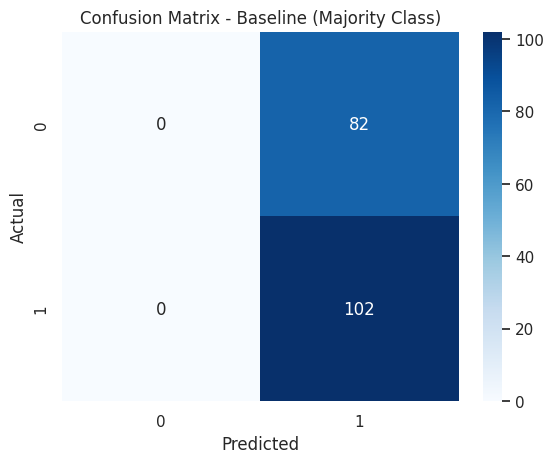

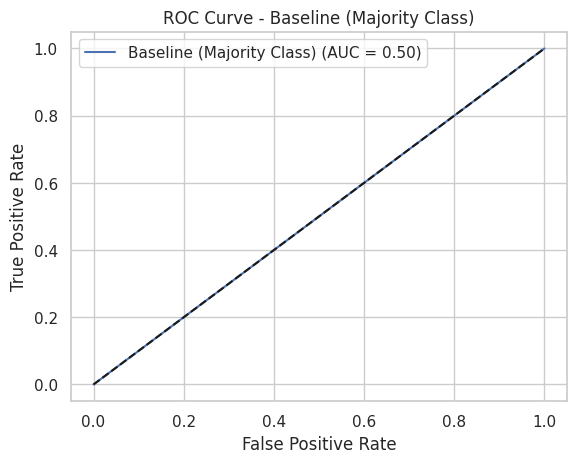

In [ ]:
# Baseline model: always predict the majority class from y_train
from sklearn.metrics import accuracy_score

baseline_class = y_train.mode()[0]
baseline_pred = [baseline_class] * len(y_test)
baseline_prob = [baseline_class] * len(y_test)  # csak dummy, hogy működjön az ROC/AUC rész is

# Evaluate baseline using the same function as other models
baseline_metrics = evaluate_model(y_test, baseline_pred, baseline_prob, "Baseline (Majority Class)")

##Logistic Regression Models

###Default Logistic Regression


Logistic Regression (Default) Evaluation:
              precision    recall  f1-score   support

           0       0.91      0.83      0.87        82
           1       0.87      0.93      0.90       102

    accuracy                           0.89       184
   macro avg       0.89      0.88      0.88       184
weighted avg       0.89      0.89      0.89       184

Accuracy: 0.886 | Precision: 0.872 | Recall: 0.931 | F1-score: 0.900 | ROC AUC: 0.931


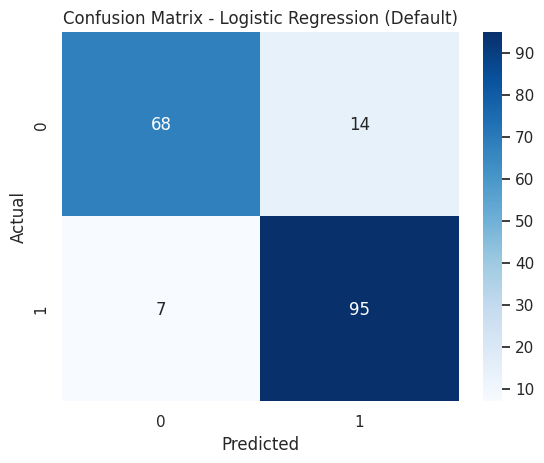

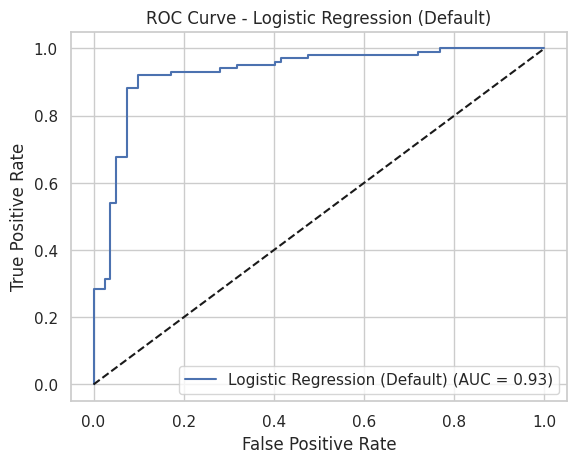

In [ ]:
# Default Logistic Regression
logreg = LogisticRegression(max_iter=2000)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)
y_prob_logreg = logreg.predict_proba(X_test)[:, 1]

#Evaluation
metrics_logreg = evaluate_model(y_test, y_pred_logreg, y_prob_logreg, "Logistic Regression (Default)")

###Logistic Regression with class_weight

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Logistic Regression (Balanced) Evaluation:
              precision    recall  f1-score   support

           0       0.91      0.84      0.87        82
           1       0.88      0.93      0.90       102

    accuracy                           0.89       184
   macro avg       0.89      0.89      0.89       184
weighted avg       0.89      0.89      0.89       184

Accuracy: 0.891 | Precision: 0.880 | Recall: 0.931 | F1-score: 0.905 | ROC AUC: 0.931


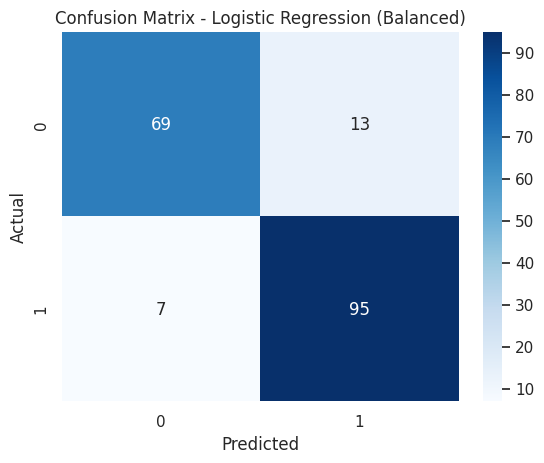

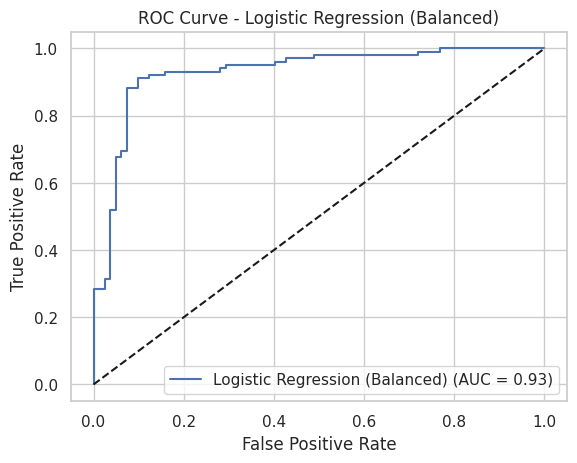

In [ ]:
# Model with class_weight='balanced' to address class imbalance
logreg_balanced = LogisticRegression(max_iter=1000, class_weight='balanced')
logreg_balanced.fit(X_train, y_train)
y_pred_logreg_bal = logreg_balanced.predict(X_test)
y_prob_logreg_bal = logreg_balanced.predict_proba(X_test)[:, 1]

# Evaluation
metrics_logreg_bal = evaluate_model(y_test, y_pred_logreg_bal, y_prob_logreg_bal, "Logistic Regression (Balanced)")

###Logistic Regression with SMOTE


Logistic Regression (SMOTE) Evaluation:
              precision    recall  f1-score   support

           0       0.91      0.87      0.89        82
           1       0.90      0.93      0.91       102

    accuracy                           0.90       184
   macro avg       0.90      0.90      0.90       184
weighted avg       0.90      0.90      0.90       184

Accuracy: 0.902 | Precision: 0.896 | Recall: 0.931 | F1-score: 0.913 | ROC AUC: 0.936


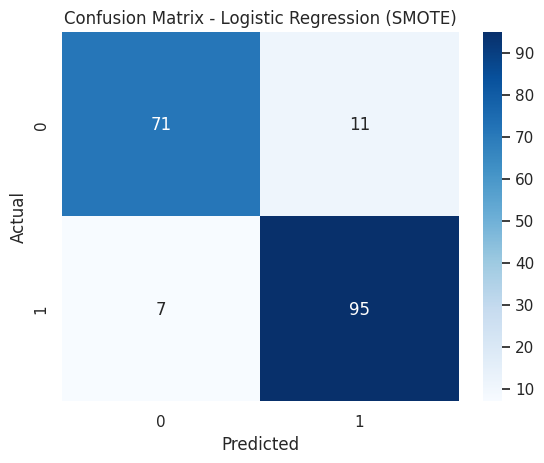

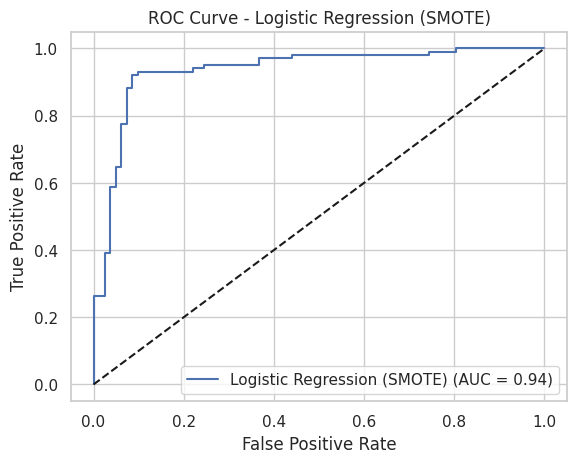

In [ ]:
#Model with SMOTE
logreg_smote = LogisticRegression(max_iter=1000)
logreg_smote.fit(X_train_smote, y_train_smote)

y_pred_logreg_smote = logreg_smote.predict(X_test)
y_prob_logreg_smote = logreg_smote.predict_proba(X_test)[:, 1]

#Evaluation
metrics_logreg_smote = evaluate_model(y_test, y_pred_logreg_smote, y_prob_logreg_smote, "Logistic Regression (SMOTE)")

##Random Forest Models

###Default Random Forest Model


Random Forest Evaluation:
              precision    recall  f1-score   support

           0       0.88      0.79      0.83        82
           1       0.85      0.91      0.88       102

    accuracy                           0.86       184
   macro avg       0.86      0.85      0.86       184
weighted avg       0.86      0.86      0.86       184

Accuracy: 0.859 | Precision: 0.845 | Recall: 0.912 | F1-score: 0.877 | ROC AUC: 0.932


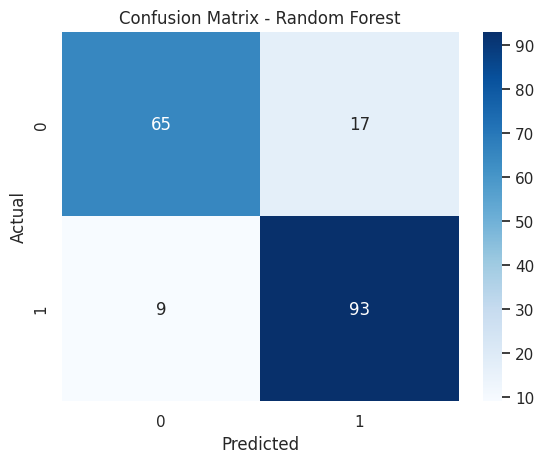

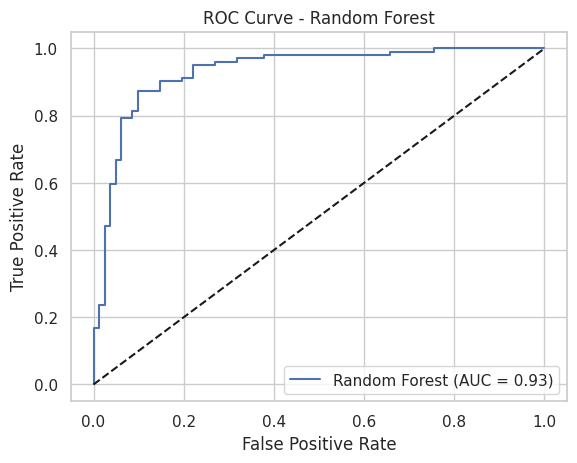

In [ ]:
# Deafult Random Forest model
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

# Run evaluation
auc_rf = evaluate_model(y_test, y_pred_rf, y_prob_rf, "Random Forest")

###Random Forest with class_weight


Random Forest (Default) Evaluation:
              precision    recall  f1-score   support

           0       0.88      0.79      0.83        82
           1       0.85      0.91      0.88       102

    accuracy                           0.86       184
   macro avg       0.86      0.85      0.86       184
weighted avg       0.86      0.86      0.86       184

Accuracy: 0.859 | Precision: 0.845 | Recall: 0.912 | F1-score: 0.877 | ROC AUC: 0.932


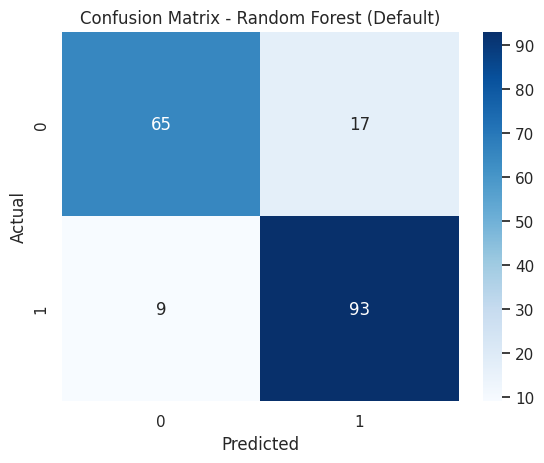

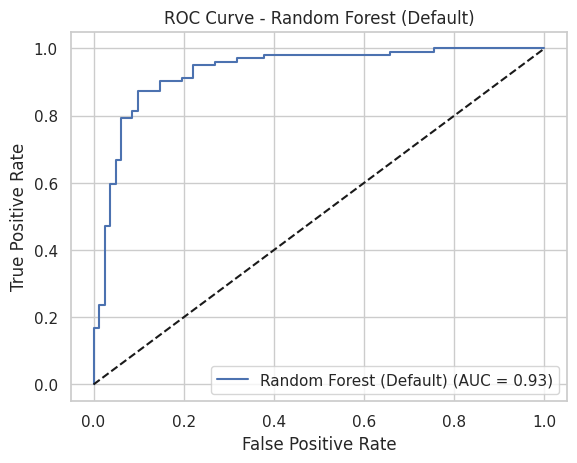

In [ ]:
# Model with class_weight='balanced' to address class imbalance
rf_balanced = RandomForestClassifier(n_estimators=100, max_depth=5, class_weight='balanced', random_state=42)
rf_balanced.fit(X_train, y_train)
y_pred_rf_bal = rf_balanced.predict(X_test)
y_prob_rf_bal = rf_balanced.predict_proba(X_test)[:, 1]

# Evaluation
metrics_rf = evaluate_model(y_test, y_pred_rf, y_prob_rf, "Random Forest (Default)")

###Random Forest with SMOTE


Random Forest (SMOTE) Evaluation:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87        82
           1       0.89      0.89      0.89       102

    accuracy                           0.88       184
   macro avg       0.88      0.88      0.88       184
weighted avg       0.88      0.88      0.88       184

Accuracy: 0.880 | Precision: 0.892 | Recall: 0.892 | F1-score: 0.892 | ROC AUC: 0.940


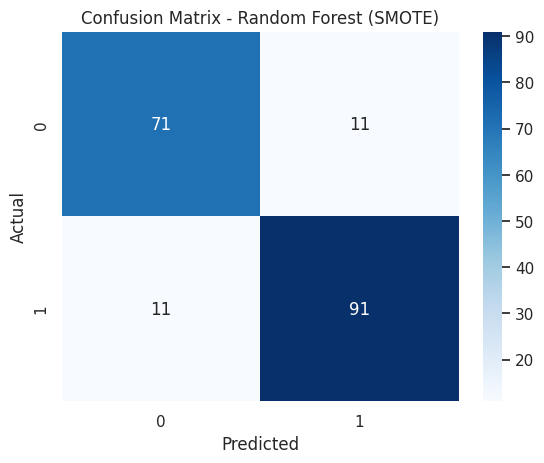

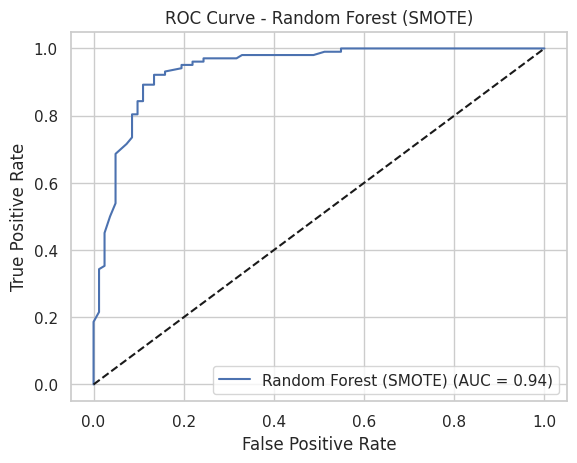

In [ ]:
# Fit a model on SMOTE-resampled data
rf_smote = RandomForestClassifier(n_estimators=100, random_state=42)
rf_smote.fit(X_train_smote, y_train_smote)

y_pred_rf_smote = rf_smote.predict(X_test)
y_prob_rf_smote = rf_smote.predict_proba(X_test)[:, 1]

# Evaluate
metrics_rf_smote = evaluate_model(y_test, y_pred_rf_smote, y_prob_rf_smote, "Random Forest (SMOTE)")

###Random Forest with Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter optimization for Random Forest
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 10, None],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5]
}

grid_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)

print("Best parameters:", grid_rf.best_params_)
print("Best CV F1-score:", grid_rf.best_score_)

Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 150}
Best CV F1-score: 0.8848733217059813



Random Forest (Tuned) Evaluation:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87        82
           1       0.89      0.89      0.89       102

    accuracy                           0.88       184
   macro avg       0.88      0.88      0.88       184
weighted avg       0.88      0.88      0.88       184

Accuracy: 0.880 | Precision: 0.892 | Recall: 0.892 | F1-score: 0.892 | ROC AUC: 0.933


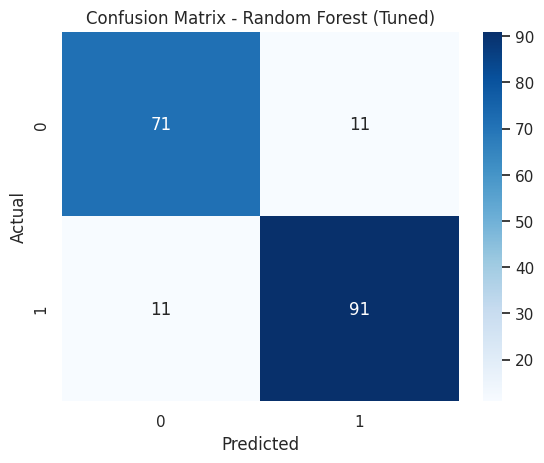

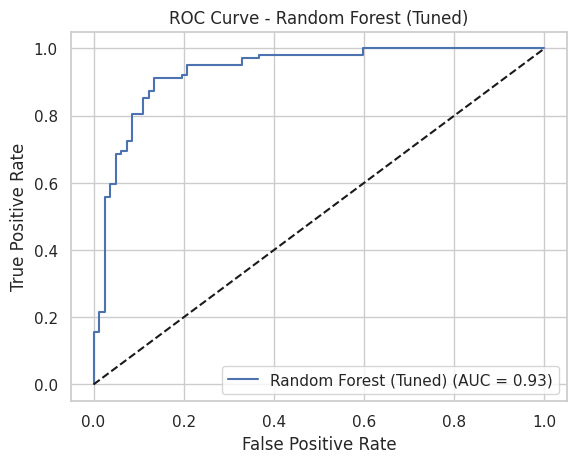

In [ ]:
# Evaluate best model on test set
best_rf = grid_rf.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)
y_prob_best_rf = best_rf.predict_proba(X_test)[:, 1]
metrics_rf_tuned = evaluate_model(y_test, y_pred_best_rf, y_prob_best_rf, "Random Forest (Tuned)")

##Deep Learning Model

In [ ]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [ ]:
# Import
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Deep Learning model for Heart Disease Prediction
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Mivel bináris osztályozás
])

# Compile
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

# Early stopping to avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.5196 - auc: 0.5371 - loss: 13.1302 - val_accuracy: 0.6939 - val_auc: 0.6909 - val_loss: 1.3397
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5371 - auc: 0.5323 - loss: 9.9438 - val_accuracy: 0.6054 - val_auc: 0.7087 - val_loss: 1.5247
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5695 - auc: 0.5569 - loss: 7.5437 - val_accuracy: 0.5986 - val_auc: 0.7066 - val_loss: 1.8320
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6217 - auc: 0.6275 - loss: 4.1854 - val_accuracy: 0.6327 - val_auc: 0.7181 - val_loss: 1.1494
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6101 - auc: 0.6277 - loss: 3.0619 - val_accuracy: 0.5986 - val_auc: 0.7043 - val_loss: 1.3686
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5438 - auc: 0.5540 - loss: 3.7468 - val_accuracy: 0.6054 - val_auc: 0.7029 - val_loss: 1.0013
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc

###Prediction and Evaluation

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

Deep Learning (MLP) Evaluation:
              precision    recall  f1-score   support

           0       0.58      0.88      0.70        82
           1       0.83      0.49      0.62       102

    accuracy                           0.66       184
   macro avg       0.71      0.68      0.66       184
weighted avg       0.72      0.66      0.65       184

Accuracy: 0.663 | Precision: 0.833 | Recall: 0.490 | F1-score: 0.617 | ROC AUC: 0.806


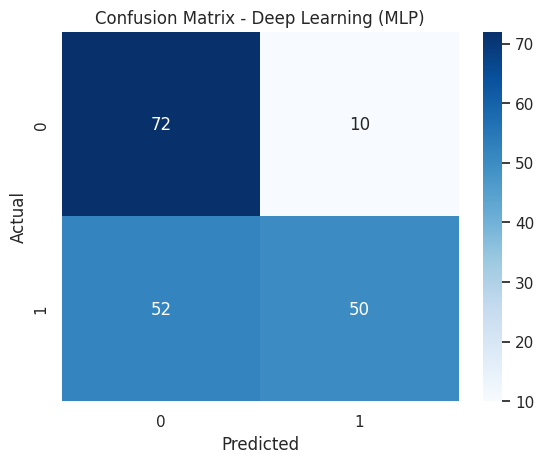

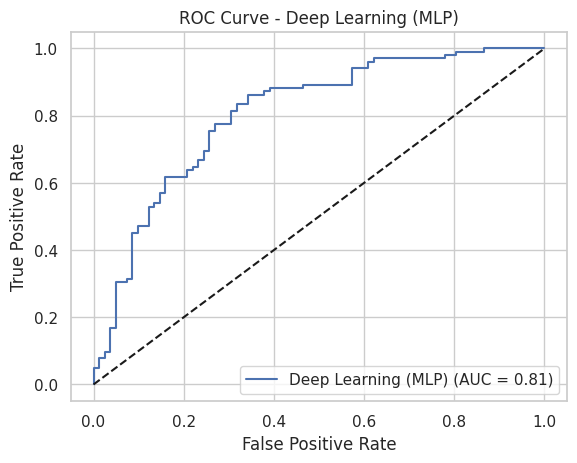

In [ ]:
# Predict
y_prob_dl = model.predict(X_test).flatten()
y_pred_dl = (y_prob_dl >= 0.5).astype(int)

# Evaluate
metrics_dl = evaluate_model(y_test, y_pred_dl, y_prob_dl, "Deep Learning (MLP)")

###Learning curves

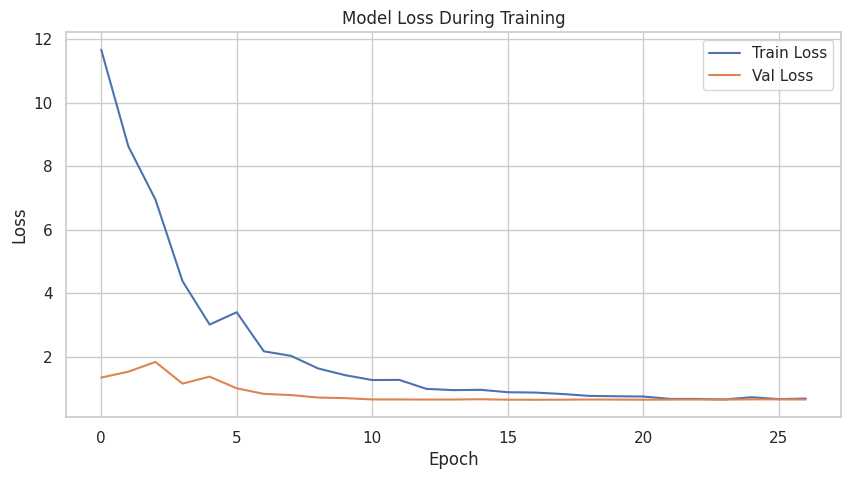

In [ ]:
# Learning curves
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Model Loss During Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

##Compare Train and Test Performance

In [ ]:
def compare_train_test(model, X_train, y_train, X_test, y_test, model_name, is_keras=False):
    if is_keras:
        y_train_prob = model.predict(X_train).flatten()
        y_test_prob = model.predict(X_test).flatten()
    else:
        y_train_prob = model.predict_proba(X_train)[:, 1]
        y_test_prob = model.predict_proba(X_test)[:, 1]

    y_train_pred = (y_train_prob >= 0.5).astype(int)
    y_test_pred = (y_test_prob >= 0.5).astype(int)

    def get_metrics(y_true, y_pred, y_prob):
        return {
            "Accuracy": accuracy_score(y_true, y_pred),
            "Precision": precision_score(y_true, y_pred),
            "Recall": recall_score(y_true, y_pred),
            "F1 Score": f1_score(y_true, y_pred),
            "ROC AUC": roc_auc_score(y_true, y_prob)
        }

    train_metrics = get_metrics(y_train, y_train_pred, y_train_prob)
    test_metrics = get_metrics(y_test, y_test_pred, y_test_prob)

    comparison_df = pd.DataFrame([train_metrics, test_metrics], index=["Train", "Test"])
    print(f"\nTrain vs. Test Performance for {model_name}")
    display(comparison_df.round(3))

    return train_metrics, test_metrics

###Run for both models

In [ ]:
compare_train_test(logreg, X_train, y_train, X_test, y_test, "Logistic Regression")
compare_train_test(rf, X_train, y_train, X_test, y_test, "Random Forest")
compare_train_test(model, X_train, y_train, X_test, y_test, "Deep Learning (MLP)", is_keras=True)


Train vs. Test Performance for Logistic Regression


Accuracy  Precision  Recall  F1 Score  ROC AUC
Train     0.862      0.866   0.889     0.877    0.933
Test      0.886      0.872   0.931     0.900    0.931


Train vs. Test Performance for Random Forest


Accuracy  Precision  Recall  F1 Score  ROC AUC
Train     0.887      0.871   0.933     0.901    0.961
Test      0.859      0.845   0.912     0.877    0.932

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

Train vs. Test Performance for Deep Learning (MLP)


Accuracy  Precision  Recall  F1 Score  ROC AUC
Train     0.646      0.826   0.456     0.587    0.777
Test      0.663      0.833   0.490     0.617    0.806

({'Accuracy': 0.6457765667574932,
  'Precision': 0.8258928571428571,
  'Recall': 0.45566502463054187,
  'F1 Score': 0.5873015873015873,
  'ROC AUC': np.float64(0.7767857142857142)},
 {'Accuracy': 0.6630434782608695,
  'Precision': 0.8333333333333334,
  'Recall': 0.49019607843137253,
  'F1 Score': 0.6172839506172839,
  'ROC AUC': np.float64(0.806312769010043)})

##Final Model Comaprison

In [ ]:
def evaluate_model(y_true, y_pred, y_prob, model_name):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)

    print(f"\n{model_name} Evaluation:")
    print(classification_report(y_true, y_pred))
    print(f"Accuracy: {acc:.3f} | Precision: {prec:.3f} | Recall: {rec:.3f} | F1-score: {f1:.3f} | ROC AUC: {auc:.3f}")

    # Confusion matrix
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Return metrics as dict
    return {
        'Model': model_name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-score': f1,
        'ROC AUC': auc
    }


LogReg Evaluation:
              precision    recall  f1-score   support

           0       0.91      0.83      0.87        82
           1       0.87      0.93      0.90       102

    accuracy                           0.89       184
   macro avg       0.89      0.88      0.88       184
weighted avg       0.89      0.89      0.89       184

Accuracy: 0.886 | Precision: 0.872 | Recall: 0.931 | F1-score: 0.900 | ROC AUC: 0.931


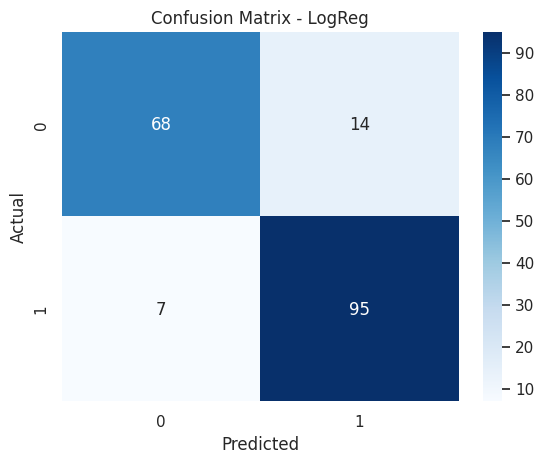

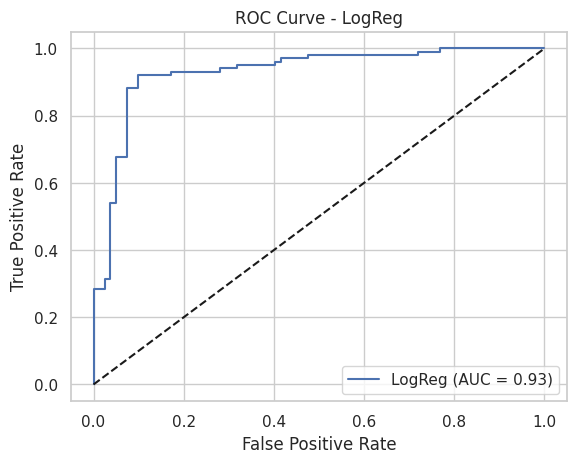


LogReg Balanced Evaluation:
              precision    recall  f1-score   support

           0       0.91      0.84      0.87        82
           1       0.88      0.93      0.90       102

    accuracy                           0.89       184
   macro avg       0.89      0.89      0.89       184
weighted avg       0.89      0.89      0.89       184

Accuracy: 0.891 | Precision: 0.880 | Recall: 0.931 | F1-score: 0.905 | ROC AUC: 0.931


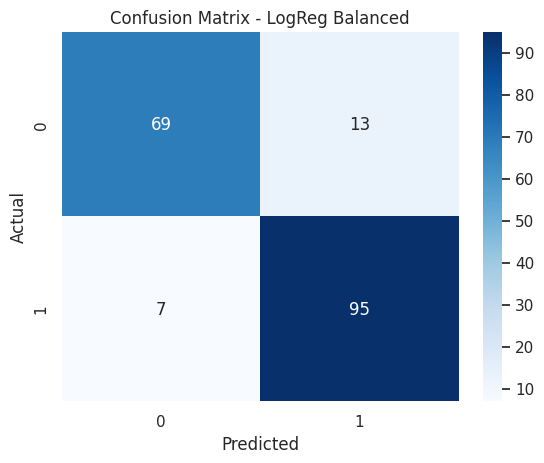

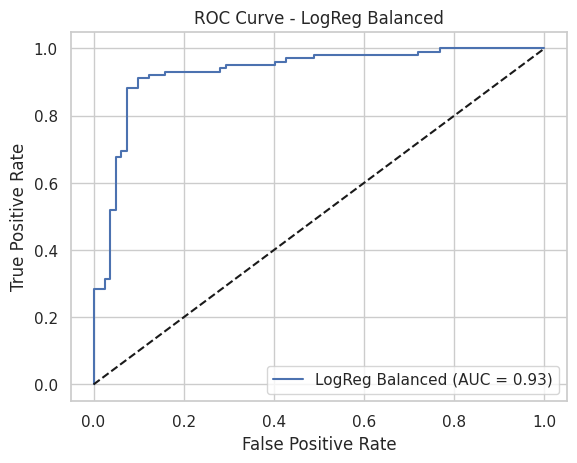


LogReg SMOTE Evaluation:
              precision    recall  f1-score   support

           0       0.91      0.87      0.89        82
           1       0.90      0.93      0.91       102

    accuracy                           0.90       184
   macro avg       0.90      0.90      0.90       184
weighted avg       0.90      0.90      0.90       184

Accuracy: 0.902 | Precision: 0.896 | Recall: 0.931 | F1-score: 0.913 | ROC AUC: 0.936


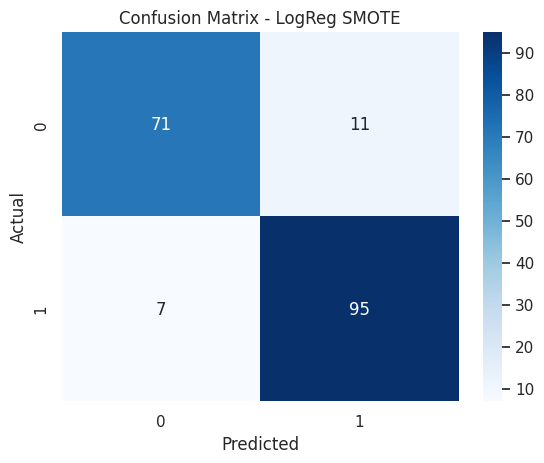

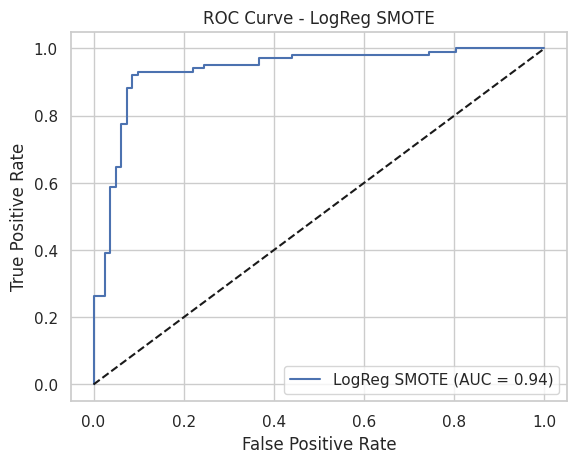


RF Evaluation:
              precision    recall  f1-score   support

           0       0.88      0.79      0.83        82
           1       0.85      0.91      0.88       102

    accuracy                           0.86       184
   macro avg       0.86      0.85      0.86       184
weighted avg       0.86      0.86      0.86       184

Accuracy: 0.859 | Precision: 0.845 | Recall: 0.912 | F1-score: 0.877 | ROC AUC: 0.932


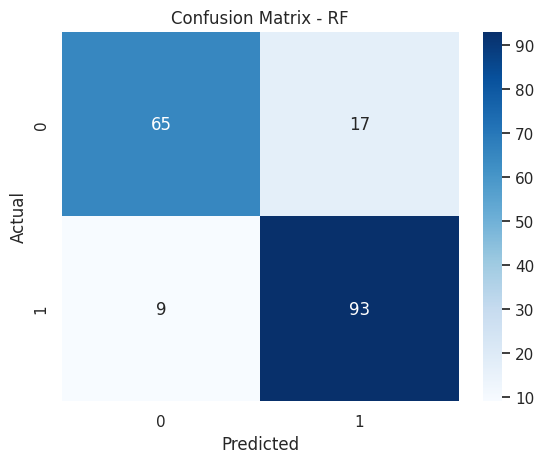

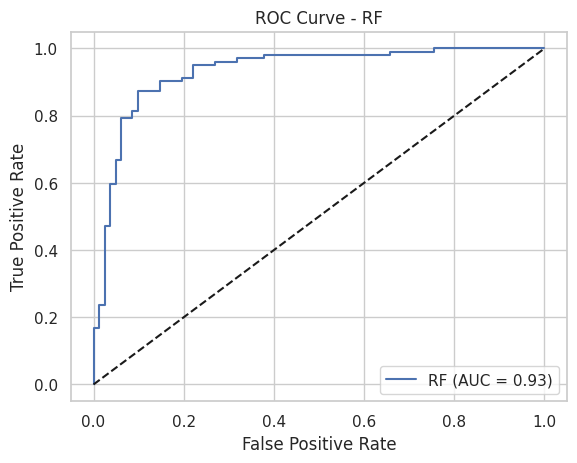


RF Balanced Evaluation:
              precision    recall  f1-score   support

           0       0.87      0.82      0.84        82
           1       0.86      0.90      0.88       102

    accuracy                           0.86       184
   macro avg       0.86      0.86      0.86       184
weighted avg       0.86      0.86      0.86       184

Accuracy: 0.864 | Precision: 0.860 | Recall: 0.902 | F1-score: 0.880 | ROC AUC: 0.928


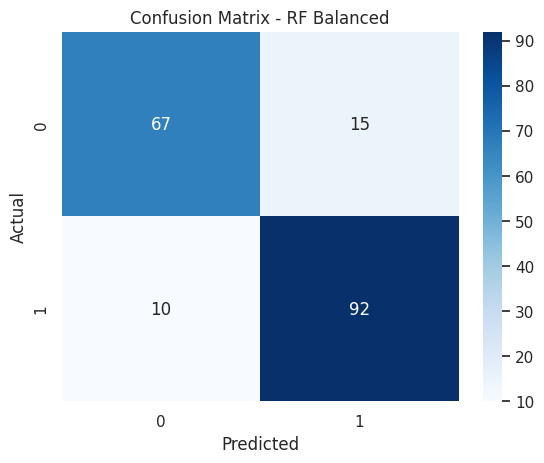

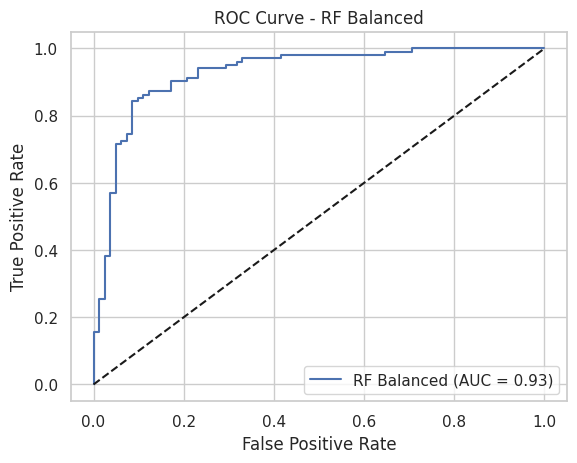


RF SMOTE Evaluation:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87        82
           1       0.89      0.89      0.89       102

    accuracy                           0.88       184
   macro avg       0.88      0.88      0.88       184
weighted avg       0.88      0.88      0.88       184

Accuracy: 0.880 | Precision: 0.892 | Recall: 0.892 | F1-score: 0.892 | ROC AUC: 0.940


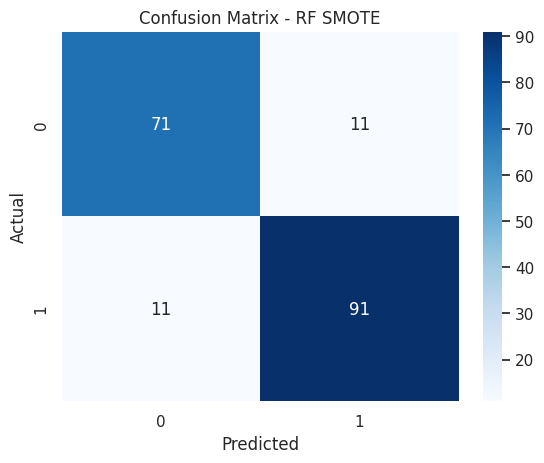

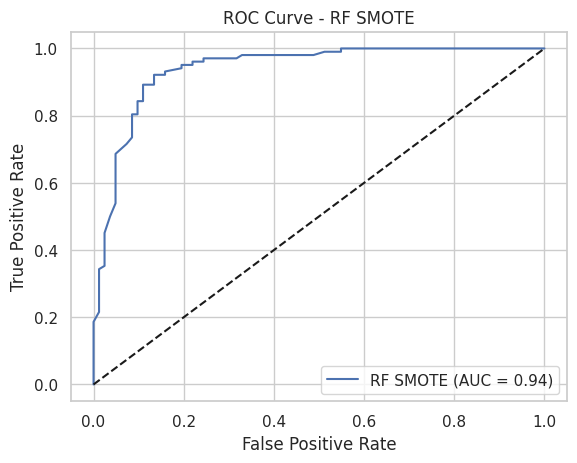


RF Tuned Evaluation:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87        82
           1       0.89      0.89      0.89       102

    accuracy                           0.88       184
   macro avg       0.88      0.88      0.88       184
weighted avg       0.88      0.88      0.88       184

Accuracy: 0.880 | Precision: 0.892 | Recall: 0.892 | F1-score: 0.892 | ROC AUC: 0.933


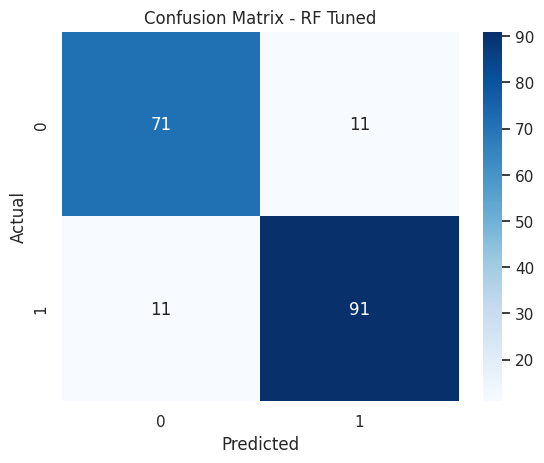

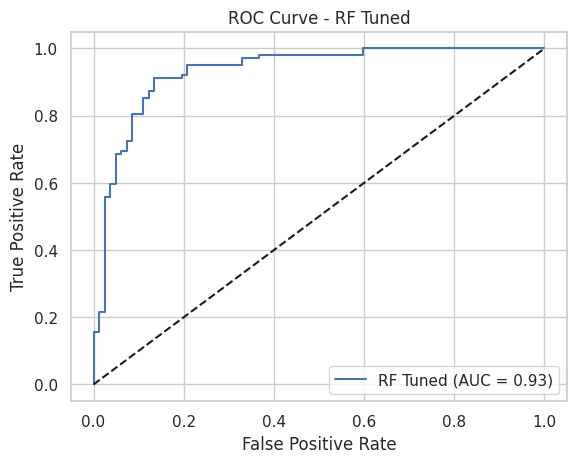


Deep Learning (MLP) Evaluation:
              precision    recall  f1-score   support

           0       0.58      0.88      0.70        82
           1       0.83      0.49      0.62       102

    accuracy                           0.66       184
   macro avg       0.71      0.68      0.66       184
weighted avg       0.72      0.66      0.65       184

Accuracy: 0.663 | Precision: 0.833 | Recall: 0.490 | F1-score: 0.617 | ROC AUC: 0.806


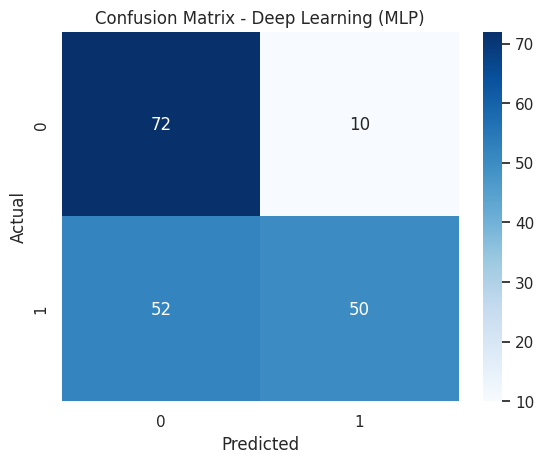

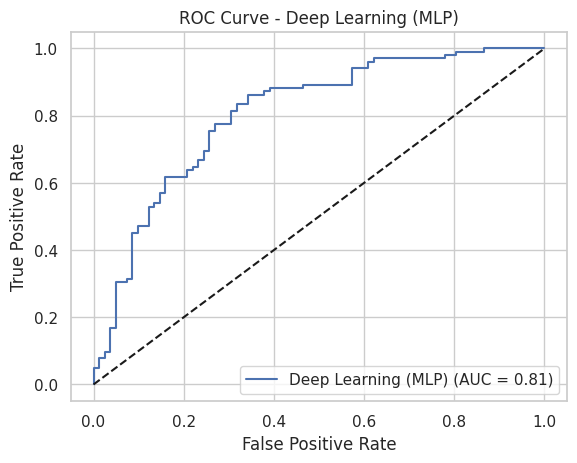

In [ ]:
results = []

# Logistic Regression (default)
results.append(evaluate_model(y_test, y_pred_logreg, y_prob_logreg, "LogReg"))

# Logistic Regression (class_weight)
results.append(evaluate_model(y_test, y_pred_logreg_bal, y_prob_logreg_bal, "LogReg Balanced"))

# Logistic Regression (SMOTE)
results.append(evaluate_model(y_test, y_pred_logreg_smote, y_prob_logreg_smote, "LogReg SMOTE"))

# Random Forest (default)
results.append(evaluate_model(y_test, y_pred_rf, y_prob_rf, "RF"))

# Random Forest (balanced)
results.append(evaluate_model(y_test, y_pred_rf_bal, y_prob_rf_bal, "RF Balanced"))

# Random Forest (SMOTE)
results.append(evaluate_model(y_test, y_pred_rf_smote, y_prob_rf_smote, "RF SMOTE"))

# Random Forest (tuned)
results.append(evaluate_model(y_test, y_pred_best_rf, y_prob_best_rf, "RF Tuned"))

# Deep Learning
results.append(evaluate_model(y_test, y_pred_dl, y_prob_dl, "Deep Learning (MLP)"))

In [ ]:
import pandas as pd
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="F1-score", ascending=False)
display(results_df)

Model  Accuracy  Precision    Recall  F1-score   ROC AUC
2         LogReg SMOTE  0.902174   0.896226  0.931373  0.913462  0.935677
1      LogReg Balanced  0.891304   0.879630  0.931373  0.904762  0.930536
0               LogReg  0.885870   0.871560  0.931373  0.900474  0.930655
5             RF SMOTE  0.880435   0.892157  0.892157  0.892157  0.939802
6             RF Tuned  0.880435   0.892157  0.892157  0.892157  0.932927
4          RF Balanced  0.864130   0.859813  0.901961  0.880383  0.927666
3                   RF  0.858696   0.845455  0.911765  0.877358  0.932090
7  Deep Learning (MLP)  0.663043   0.833333  0.490196  0.617284  0.806313

In [ ]:
# Export results table to CSV (optional for report)
results_df.to_csv("model_comparison_results.csv", index=False)

##Cross Validation

In [ ]:
cv_scores_rf = cross_val_score(rf, X, y, cv=5, scoring='roc_auc')
cv_scores_logreg = cross_val_score(logreg, X_scaled, y, cv=5, scoring='roc_auc')

print("Random Forest CV ROC-AUC:", round(cv_scores_rf.mean(), 3))
print("Logistic Regression CV ROC-AUC:", round(cv_scores_logreg.mean(), 3))

Random Forest CV ROC-AUC: 0.91
Logistic Regression CV ROC-AUC: 0.908


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Logistic Regression Evaluation:
              precision    recall  f1-score   support

           0       0.91      0.83      0.87        82
           1       0.87      0.93      0.90       102

    accuracy                           0.89       184
   macro avg       0.89      0.88      0.88       184
weighted avg       0.89      0.89      0.89       184

Accuracy: 0.886 | Precision: 0.872 | Recall: 0.931 | F1-score: 0.900 | ROC AUC: 0.931


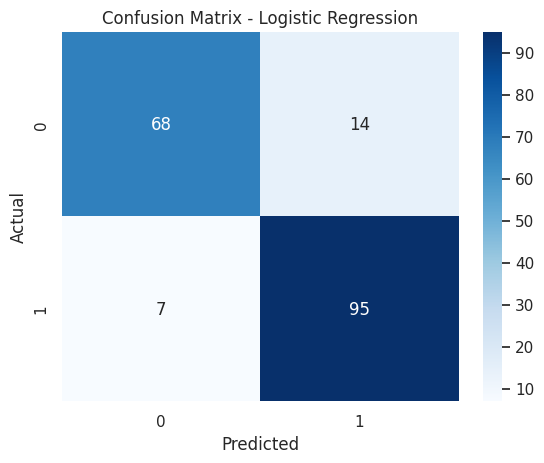

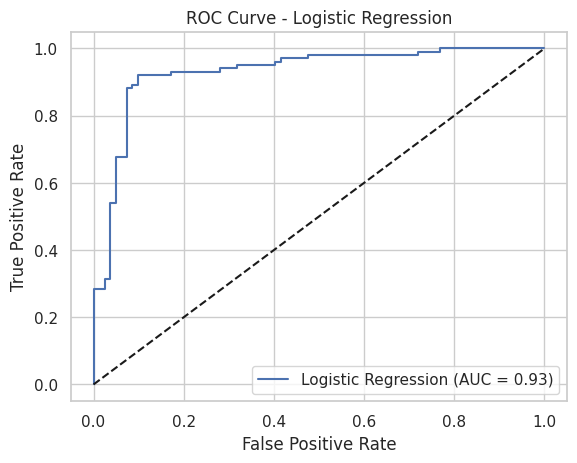


Random Forest Evaluation:
              precision    recall  f1-score   support

           0       0.86      0.85      0.86        82
           1       0.88      0.89      0.89       102

    accuracy                           0.88       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.87      0.88      0.87       184

Accuracy: 0.875 | Precision: 0.883 | Recall: 0.892 | F1-score: 0.888 | ROC AUC: 0.931


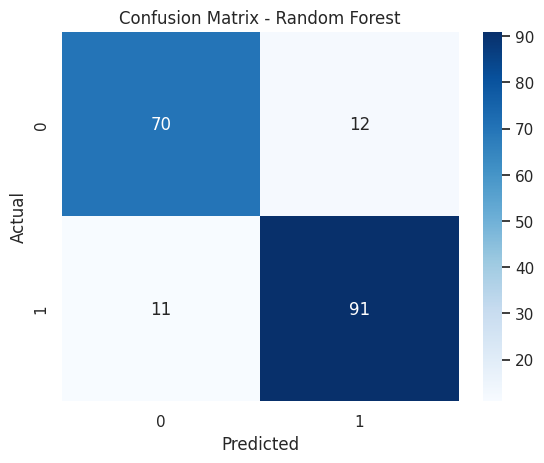

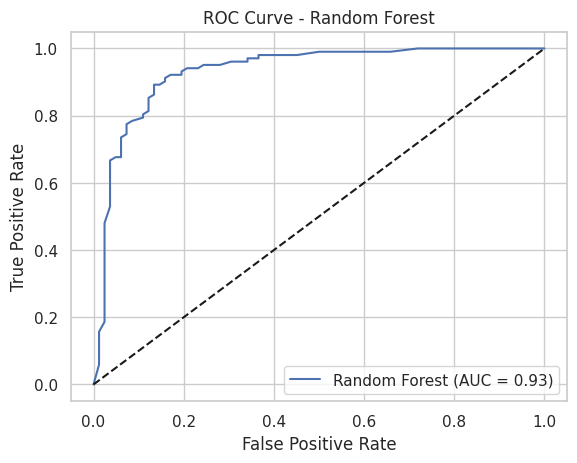

In [ ]:
# For logistic regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)
y_prob_logreg = logreg.predict_proba(X_test)[:, 1]

# For random forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

# Run evaluations
auc_logreg = evaluate_model(y_test, y_pred_logreg, y_prob_logreg, "Logistic Regression")
auc_rf = evaluate_model(y_test, y_pred_rf, y_prob_rf, "Random Forest")

##Choosing the best model

In [ ]:
#Choosing best model based on F1 score
best_model_name = results_df.iloc[0]['Model']
print(f"Thebest model based on F1 score: {best_model_name}")


Thebest model based on F1 score: LogReg SMOTE


##Saving the best model

In [ ]:
import joblib
joblib.dump(best_rf, "best_model.pkl")

['best_model.pkl']

In [ ]:
model.save("best_mlp_model.h5")

In [ ]:
if best_model_name == "RF Tuned":
    joblib.dump(best_rf, "best_model.pkl")
elif best_model_name == "RF":
    joblib.dump(rf, "best_model.pkl")
elif best_model_name == "LogReg":
    joblib.dump(logreg, "best_model.pkl")
elif best_model_name == "LogReg SMOTE":
    joblib.dump(logreg_smote, "best_model.pkl")
elif best_model_name == "Deep Learning (MLP)":
    model.save("best_dl_model.h5")
else:
    print("Best model")